In [1]:
import sys
import numpy as np
import math
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nLenslet = 26
n = 18
nPx = n*nLenslet+1
print "pupil sampling:      %d pixel"%nPx
detectorRes = 5.0*n*nLenslet/4.0
print "detector resolution: %d pixel"%detectorRes
diam = 26
alpha = 5.0  # radius of circle where GSs are located [in arcmin]
N_GS =  3   # NUMBER of GSs
zenith_angle  = np.ones((1,N_GS))*alpha*ceo.constants.ARCMIN2RAD # in radians
azimuth_angle = np.arange(N_GS)*360.0/N_GS # in degrees
gs    = ceo.Source("I",zenith=zenith_angle,azimuth=azimuth_angle*math.pi/180,
                       rays_box_size=diam,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
#imgr = ceo.ShackHartmann(1, nPx-1, D ,DFT_osf=4,N_PX_IMAGE=0.5*(nPx-1))nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n,BIN_IMAGE=2,N_GS=N_GS
wfs = ceo.ShackHartmann(nLenslet, n, diam/nLenslet,DFT_osf=5,N_PX_IMAGE=4*n,BIN_IMAGE=4,N_GS=N_GS)
gmt = ceo.GMT_MX(diam,nPx,M1_radial_order=6)

pupil sampling:      469 pixel
detector resolution: 585 pixel


<matplotlib.colorbar.Colorbar instance at 0x2b614e1f1dd0>

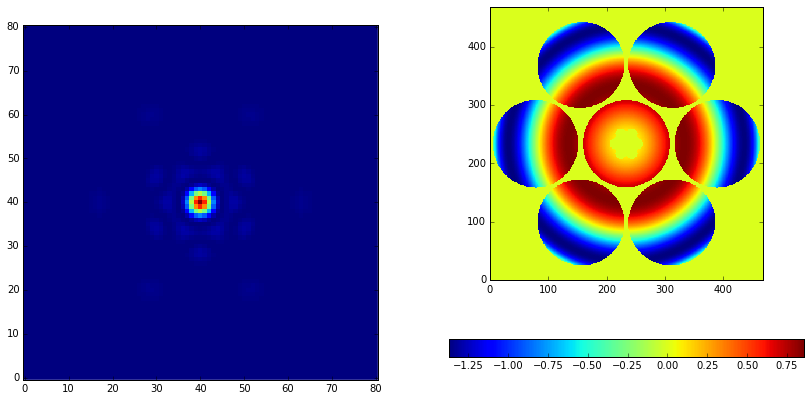

In [3]:
src = ceo.Source("I",rays_box_size=diam,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
gmt.propagate(src)
imgr = ceo.Imaging(1, nPx-1,DFT_osf=4,N_PX_IMAGE=81,N_SOURCE=src.N_SRC)
imgr.propagate(src)
fig, (ax1,ax2) = subplots(nrows=1,ncols=2)
fig.set_size_inches((14,7))
ax1.imshow((imgr.frame.host().T),interpolation='none',origin='lower')
h2 = ax2.imshow(src.wavefront.phase.host(shape=(nPx*src.N_SRC,nPx),units='nm').T,interpolation='none',origin='lower')
colorbar(h2,ax=ax2,orientation='horizontal')

#Calibrations
## Wavefront sensors

[ 1277.90515137  1278.50878906  1278.47766113]


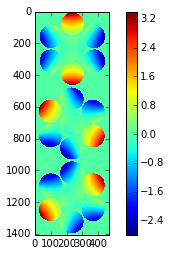

In [4]:
#gmt.M1.update(origin=[0e-6,0.0,0.0],idx=1)
#gs.reset()
gmt.reset()
gs.reset()
gmt.propagate(gs)
ps0 = gs.phase.host(units='micron')
imshow(ps0,interpolation='None')
colorbar()
print gs.wavefront.rms()*1e9
wfs.calibrate(gs,0.8)

In [5]:
print wfs.frame.shape
print "Pixel size: %.3farcsec"%(wfs.BIN_IMAGE*wfs.pixel_scale_arcsec)
print "Field of view: %.3farcsec"%(wfs.BIN_IMAGE*wfs.pixel_scale_arcsec*wfs.N_PX_LENSLET)

(1404, 468)
Pixel size: 0.130arcsec
Field of view: 2.346arcsec


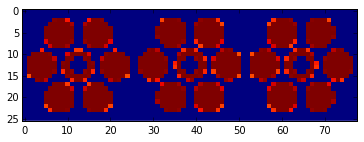

In [6]:
imshow(wfs.flux.host().T,interpolation='none')

## M2 tip-tilt

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------
M2 tip-tilt interaction matrix condition #:   1.10


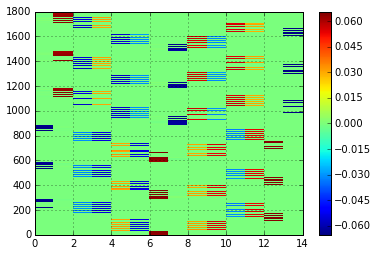

In [7]:
D2tt = gmt.calibrate(wfs,gs,mirror="M2",mode="segment tip-tilt",stroke=200*ceo.constants.MAS2RAD)
fig, ax = subplots()
h = ax.pcolor(D2tt)
colorbar(h)
grid()
print "M2 tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D2tt)

## M2 x,y,z translations with M2 segment tip-til removed

In [8]:
mic2m = 1e-6
def M2_xyz(xyz,segId):
    gmt.reset()
    gmt.M2.update(origin=xyz,idx=segId)
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

In [9]:
def M2_seg_TT(origin=[0,0,0],originId=0):
    M = np.linalg.pinv(D2tt)
    M2_R = np.zeros((14,1))
    for kStep in range(4):
        M2_R += np.dot(M,wfs.valid_slopes.host().T)
    #    print M2_R/mas2rad
    #    print M2_R.shape
        for k in range(7):
            R = [-M2_R[2*k,0],-M2_R[2*k+1,0],0]
            if originId==(k+1):
                gmt.M2.update(origin=origin,euler_angles=R,idx=k+1)
            else:
                gmt.M2.update(euler_angles=R,idx=k+1)
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
#    imshow(1e3*wfs.c.host(shape=(nLenslet*2,nLenslet),units='arcsec').T,interpolation='none')
#    colorbar()
    return wfs.valid_slopes.host().ravel()

In [10]:
stroke = 10
c_shape = (gs.N_SRC*nLenslet*2,nLenslet)
cp_x = cm_x = np.zeros(shape=c_shape)
cp_y = cm_y = np.zeros(shape=c_shape)
cp_z = cm_z = np.zeros(shape=c_shape)
ps_x = ps_y = ps_z = np.zeros(shape=gs.phase.shape)
D2xyz_2 = np.zeros((wfs.n_valid_slopes,3*7))
l = -1
sys.stdout.write("Segment #: ")
for k in range(1,8):
    sys.stdout.write("%d "%k)
    xyz = [stroke*mic2m,0,0]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_x = cp_x + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    
    ps_x = ps_x + mask*(ps - ps0)
    xyz = [-stroke*mic2m,0,0]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_x = cm_x + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

    xyz = [0,stroke*mic2m,0]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_y = cp_y + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    ps_y = ps_y + mask*(ps - ps0)
    xyz = [0,-stroke*mic2m,0]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_y = cm_y + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

    xyz = [0,0,stroke*mic2m]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_z = cp_z + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    ps_z = ps_z + mask*(ps - ps0)
    xyz = [0,0,-stroke*mic2m]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_z = cm_z + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

Segment #: 1 2 3 4 5 6 7 

<matplotlib.colorbar.Colorbar instance at 0x2b614fa47c68>

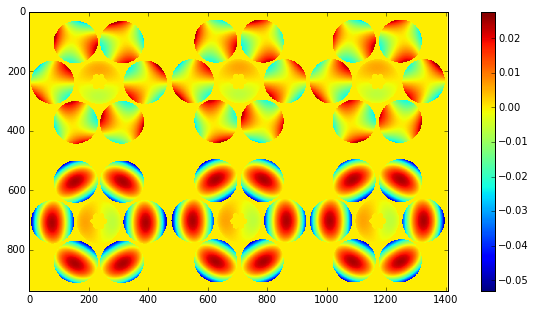

In [11]:
fig, ax2 = subplots()
fig.set_size_inches(12,5)
#h2=ax2.imshow(np.concatenate((cp_z,cm_z),axis=1).T,interpolation='none')
h2=ax2.imshow(np.concatenate((ps_x,ps_y),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)

<matplotlib.colorbar.Colorbar instance at 0x2b614fbca290>

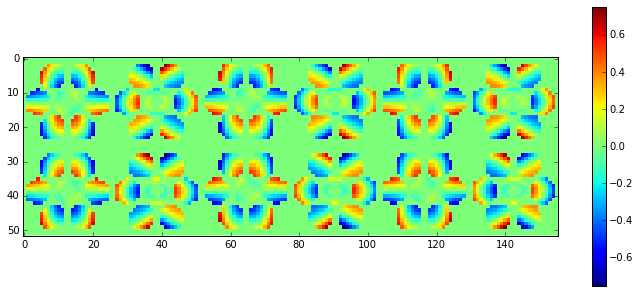

In [12]:
fig, ax2 = subplots()
fig.set_size_inches(12,5)
h2=ax2.imshow(np.concatenate((cp_x,cm_x),axis=1).T,interpolation='none')
#h2=ax2.imshow(np.concatenate((ps_x,ps_y),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)

M2 x,y,x translation interaction matrix condition #:  41.34


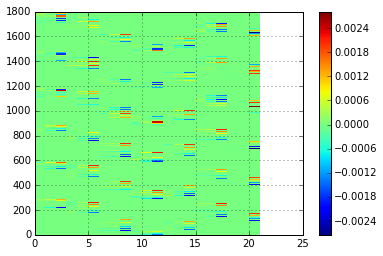

In [13]:
fig, ax = subplots()
h = ax.pcolor(D2xyz_2)
colorbar(h)
grid()
print "M2 x,y,x translation interaction matrix condition #: %6.2f"%np.linalg.cond(D2xyz_2)

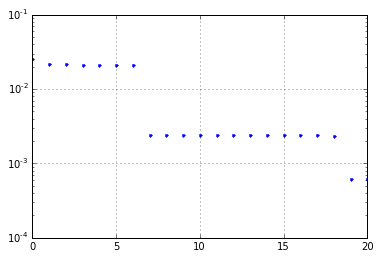

In [14]:
D =  ( D2xyz_2  )
U,S,V = np.linalg.svd(D)
semilogy(S,'.')
grid()

## M1 global tip-tilt with M2 segment tip-til removed

In [15]:
mas2rad = 1e-3*math.pi/180/3600
def M1_global_TT(tip,tilt):
    gmt.reset()
    gmt.M1.global_tiptilt(tip,tilt)
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

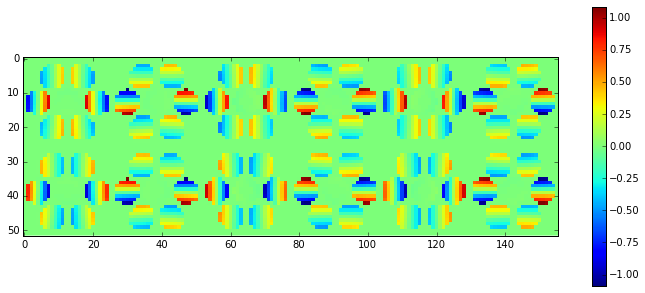

In [16]:
amp = 50*ceo.constants.MAS2RAD
M1_global_TT(amp,0)
sp = M2_seg_TT()
fig, ax2 = subplots()
fig.set_size_inches(12,5)
cp = 1e3*wfs.c.host(shape=(gs.N_SRC*nLenslet*2,nLenslet),units='arcsec')
M1_global_TT(-amp,0)
sm = M2_seg_TT()
cm = 1e3*wfs.c.host(shape=(gs.N_SRC*nLenslet*2,nLenslet),units='arcsec')
h2=ax2.imshow(np.concatenate((cp,cm),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)
D1gtt_2 = np.zeros((wfs.n_valid_slopes,2))
D1gtt_2[:,0] = ((sp-sm)/2)/amp

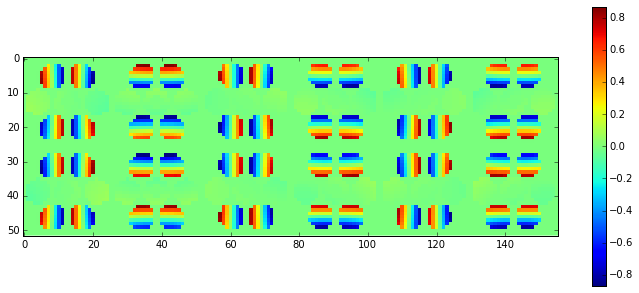

In [17]:
M1_global_TT(0,amp)
sp = M2_seg_TT()
cp = 1e3*wfs.c.host(shape=(gs.N_SRC*nLenslet*2,nLenslet),units='arcsec')
fig, ax2 = subplots()
fig.set_size_inches(12,5)
M1_global_TT(0,-amp)
sm = M2_seg_TT()
cm = 1e3*wfs.c.host(shape=(gs.N_SRC*nLenslet*2,nLenslet),units='arcsec')
h2=ax2.imshow(np.concatenate((cp,cm),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)
D1gtt_2[:,1] = ((sp-sm)/2)/amp

M1 global tip-tilt interaction matrix condition #:   1.01


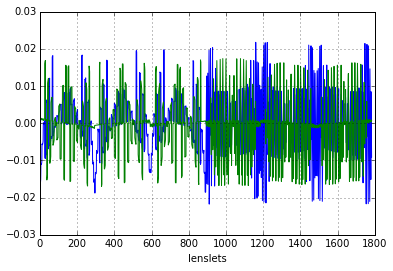

In [18]:
plot(D1gtt_2)
grid()
xlabel('lenslets')
print "M1 global tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D1gtt_2)

## M1 bending modes

In [19]:
mic2m = 1e-6
def M1_zern(zmode,zstroke,segId):
    gmt.reset()
    gmt.M1.zernike.a[segId,zmode] = zstroke
    gmt.M1.zernike.update()
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

In [20]:
zStroke = 1e-7
l = -1
zmodes = [4,5]
zmodes.extend(range(8,28))
nZernCoefs = len(zmodes)
D1z_2 = np.zeros((wfs.n_valid_slopes,7*nZernCoefs))
ps_z = np.zeros(shape=gs.phase.shape)
for kSeg in range(7):
    sys.stdout.write("Segment #%d: "%kSeg)
    for kMode in zmodes:
        sys.stdout.write("%d "%(kMode+1))
        M1_zern(kMode,zStroke,kSeg)
        sp = M2_seg_TT()
        M1_zern(kMode,-zStroke,kSeg)
        sm = M2_seg_TT()
        l += 1
        D1z_2[:,l] = ((sp-sm)/2)/(zStroke)   
    #ps_z = ps_z + gs.phase.host(units='micron') - ps0
    sys.stdout.write("\n")

Segment #0: 5 6 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
Segment #1: 5 6 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
Segment #2: 5 6 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
Segment #3: 5 6 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
Segment #4: 5 6 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
Segment #5: 5 6 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
Segment #6: 5 6 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 


Zernike modes interaction matrix condition #:   5.35


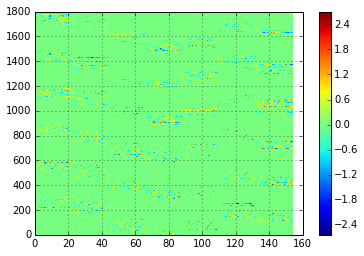

In [21]:
fig, ax = subplots()
h = ax.pcolor(D1z_2)
colorbar(h)
grid()
print "Zernike modes interaction matrix condition #: %6.2f"%np.linalg.cond(D1z_2)

# AGWS closed-loop control

## Resetting

In [22]:
gs.reset()
wfs.reset()
gmt.reset()
ps0 = gs.phase.host(units='nm').T
com1 = np.zeros((23+7*nZernCoefs,1))
com2xyz0 = np.zeros((21,1))
com2xyz0 = np.zeros((21,1))
com1[2:23] = com2xyz0
com2xyz = com1[2:23]
com2 = np.zeros((14,1))
M2 = np.linalg.pinv( D2tt )
D12 = np.concatenate( (D1gtt_2, D2xyz_2, D1z_2) , axis=1)
M12 = np.linalg.pinv( D12 )

## Initial conditions

### M1 global tip-tilt

In [23]:
com10 = np.zeros((23+7*nZernCoefs,1))
com10[0] = 50*ceo.constants.MAS2RAD
com10[1] = -30*ceo.constants.MAS2RAD

### M2 x,y and ztranslations

In [24]:
com2xyz0 = np.random.randn(21,1)*1e-6
print array_str(com2xyz0.reshape(7,3)*1e6,precision=2)

[[-0.3   0.62 -1.52]
 [ 0.33 -0.07 -1.14]
 [-0.28  0.04  1.74]
 [-0.69 -1.14 -1.7 ]
 [ 0.32 -0.44 -1.98]
 [ 0.41  0.44 -0.58]
 [ 2.89  0.31  0.72]]


### M1 bending modes (Zernike polynomials)

<matplotlib.colorbar.Colorbar instance at 0x2b615d27fc20>

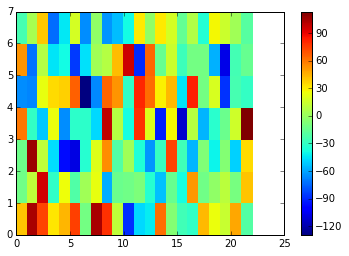

In [25]:
zern_coefs0 = np.random.randn(7,nZernCoefs)*5e-8
pcolor(zern_coefs0*1e9)
colorbar()

### M2 segment tip-tilts

In [26]:
com20  = np.random.rand(14,1)*25*ceo.constants.MAS2RAD
#com2xyz = np.zeros((21,1))
print array_str(com20.reshape(7,2)*ceo.constants.RAD2MAS,precision=2)

[[ 16.05  16.45]
 [  3.     5.44]
 [ 10.51   7.16]
 [ 16.45   1.23]
 [  4.66  11.08]
 [ 13.4   22.39]
 [ 23.81  20.33]]


## Initial on-axis PSF and wavefront

Initial WFE rms: 2534.04nm


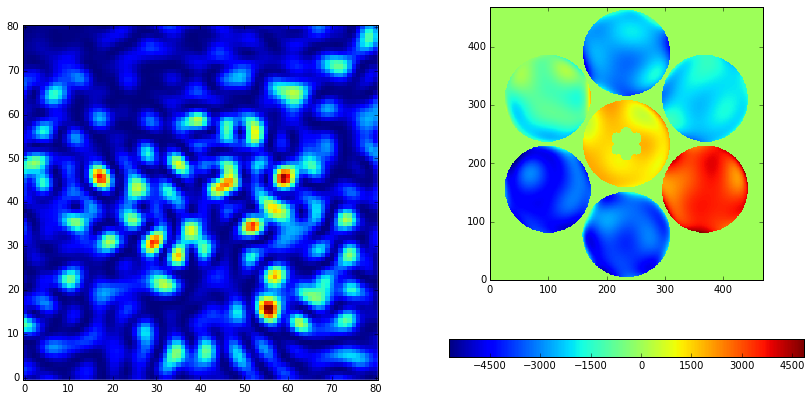

In [46]:
from IPython.display import display, clear_output

com1 = com10
gmt.M1.global_tiptilt(com1[0],com1[1])
com1[2:23] = com2xyz0
com2xyz = com1[2:23]
#com1[23:] = np.random.randn(14,1)*1e-7
for k in range(7):
    gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                  euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)
gmt.M1.zernike.a[:,zmodes] = zern_coefs0
gmt.M1.zernike.update()
com2 = com20
for k in range(7):
    gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                  euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)
    
gs.reset()
wfs.reset()

src.reset()
gmt.propagate(src)
imgr.reset()
imgr.propagate(src)
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches((14,7))
h1 = ax1.imshow(imgr.frame.host(),interpolation='none',origin='lower')
h2 = ax2.imshow(src.phase.host(units='nm'),interpolation='none',origin='lower')
colorbar(h2,ax=ax2,orientation='horizontal')
n1Step = 20
wfe_rms = np.zeros(n1Step+1)
wfe_rms[0] = src.wavefront.rms(-9)
print "Initial WFE rms: %6.2fnm"%wfe_rms[0]

## Closing the loop

### Noise condition

In [47]:
ron = 0
gs.magnitude = 0.0

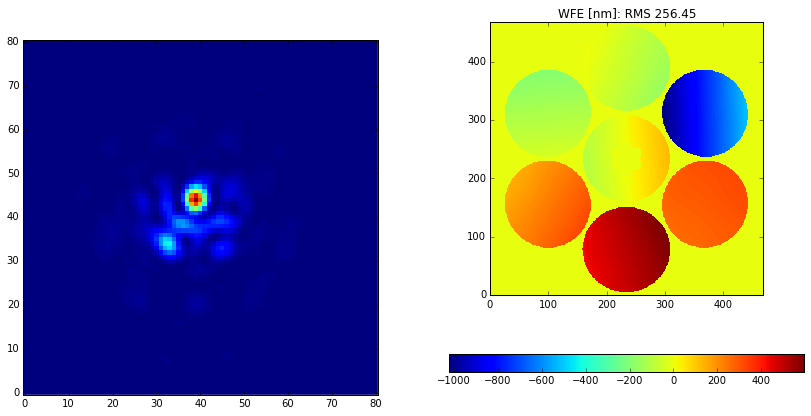

In [48]:
g1 = 0.5
g2 = 0.5
for k1Step in range(n1Step):

    for k2Step in range(10):
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
        com2 -= g2*np.dot(M2,wfs.valid_slopes.host().T)
        for k in range(7):
            gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                          euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)

    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.propagate(gs)
    wfs.readOut(30,ron)
    wfs.process()
    #wfs.analyze(gs)

    com1 -= g1*np.dot(M12,wfs.valid_slopes.host().T)
    com2xyz = com1[2:23]
    gmt.M1.global_tiptilt(com1[0],com1[1])
    gmt.M1.zernike.a[:,zmodes] = com1[23:].reshape(7,-1)
    gmt.M1.zernike.update()
    for k in range(7):
        gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                     euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)

    src.reset()
    gmt.propagate(src)
    imgr.reset()
    imgr.propagate(src)

    wfe = src.phase.host(units='nm')
    wfe_rms[k1Step+1] = 1e9*src.wavefront.rms()
    psf = imgr.frame.host()

    h1.set_data(psf)
    h1.set_clim((psf.min(),psf.max()))
    h2.set_data(wfe)
    h2.set_clim((wfe.min(),wfe.max()))
    ax2.set_title( "WFE [nm]: RMS %4.2f"%wfe_rms[k1Step])

    clear_output(wait=True)
    display(fig)
plt.close()

## Wavefront error rms

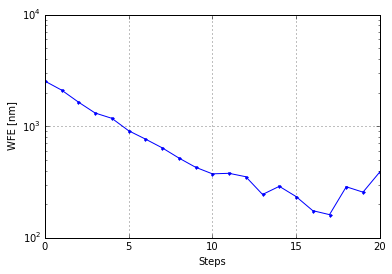

In [49]:
semilogy(wfe_rms,'.-')
grid()
xlabel('Steps')
ylabel('WFE [nm]')